# Overview
Use this notebook to convert an OCT image to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist_on_tiles.ipynb) and run.

View this colab on [Github](https://github.com/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist_on_tiles.ipynb).


# OCT→Hist (pix2pix) — Tiled Inference Variant

This notebook mirrors `run_oct2hist.ipynb` but calls **`test_on_tiles.py`**,
which runs inference on tiles with TTA. Only minor changes were made below;
all other cells are preserved.


In [ ]:
#@title Set default paths and options for tiled TTA run
# Edit these for your environment (Google Drive is a good default).
DATAROOT = "/content/drive/MyDrive/oct_data/test"  #@param {type:"string"}
CHECKPOINTS_DIR = "/content/drive/MyDrive/oct2hist_checkpoints"  #@param {type:"string"}
RESULTS_DIR = "/content/drive/MyDrive/oct2hist_results"  #@param {type:"string"}
TTA_DEBUG_DIR = "/content/drive/MyDrive/oct2hist_tta_debug"  #@param {type:"string"}
NAME = "oct2hist"  #@param {type:"string"}

# Advanced (usually keep as-is)
NETG = "resnet_9blocks"
MODEL = "pix2pix"
NUM_TEST = 1000
TTA_ITERS = 300
TTA_PATIENCE = 25
TTA_SIGMA = 7
TTA_LAMBDA_H = 1.0
TTA_LAMBDA_TV = 1e-5
TTA_DEBUG_EVERY = 10
BATCH_SIZE = 32
TTA_OVERLAP = 0.0
LEARNING_RATE = 1e-4


In [ ]:
#@title Copy test_on_tiles.py into the submodule (after cloning the repo)
import os, math

# Where the ModelInference repo will be on Colab (edit if needed)
REPO_ROOT = "/content/OCT2Hist-ModelInference"  #@param {type:"string"}
SUBMODULE_DIR = f"{REPO_ROOT}/OCT2Hist_UseModel/pytorch_CycleGAN_and_pix2pix"
os.makedirs(SUBMODULE_DIR, exist_ok=True)

# Write file
target_path = os.path.join(SUBMODULE_DIR, "test_on_tiles.py")
patched_code = r"""
"""General-purpose test script for image-to-image translation.

Once you have trained your model with train.py, you can use this script to test the model.
It will load a saved model from '--checkpoints_dir' and save the results to '--results_dir'.
"""
import os
import copy
import re
import shutil
import tempfile

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from OCT2Hist_UseModel.pytorch_CycleGAN_and_pix2pix.models.global_device import device_global
DEBUG = True
if DEBUG:
    torch.autograd.set_detect_anomaly(True)
print(f"device_global: {device_global}")
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
from PIL import Image  # noqa: F401 (kept in case PIL is needed by dataset pipeline)
# try:
#     import wandb
# except ImportError:
#     print('Warning: wandb package cannot be found. The option "--use_wandb" will result in error.')
# import torch





# ===== helpers =====
import math

def _erf_ramp(n, sigma):
    """
    Returns a 1D ramp of length n in [0,1] that transitions smoothly
    with a Gaussian CDF (erf). Centered so that middle ~ 0.5.
    """
    if n <= 1:
        return torch.ones(1, device=device_global, dtype=torch.float32)
    x = torch.arange(n, device=device_global, dtype=torch.float32)
    mid = (n - 1) / 2.0
    # erf-based S-curve; sigma in pixels controls how sharp it is
    r = 0.5 * (1.0 + torch.erf((x - mid) / (math.sqrt(2.0) * sigma)))
    return r.clamp(0, 1)  # [0,1]





def _gather_images(path, exts=(".jpg", ".jpeg", ".png", ".tif", ".tiff")):
    if os.path.isdir(path):
        files = []
        for fn in os.listdir(path):
            if fn.lower().endswith(exts):
                files.append(os.path.join(path, fn))
        files.sort()
        return files
    elif os.path.isfile(path):
        return [path]
    else:
        raise ValueError(f"Input path {path} is neither a file nor a directory.")

def _make_flat_top_mask(tile_h=256, tile_w=256, device=device_global, dtype=torch.float32, edge=24):
    """
    Flat-top raised-cosine (Tukey-like) mask in [0,1].
    - Center = 1.0 (no attenuation).
    - Only 'edge' pixels on each side are feathered.
    """
    def axis_win(n):
        if edge <= 0 or edge*2 >= n:
            return torch.ones(n, device=device, dtype=dtype)
        w = torch.ones(n, device=device, dtype=dtype)
        e = edge
        t = torch.linspace(0, 1, steps=e, device=device, dtype=dtype)
        ramp = 0.5 - 0.5 * torch.cos(torch.pi * t)  # 0→1
        w[:e] = ramp
        w[-e:] = ramp.flip(0)
        return w

    wy = axis_win(tile_h).view(tile_h, 1)
    wx = axis_win(tile_w).view(1, tile_w)
    m = wy * wx  # (H,W)
    return m  # 2D, no channel yet

def _blend_paste(acc_img, acc_wts, tile_img, mask, y, x):
    """
    acc_img: (1,3,H,W) accumulator
    acc_wts: (1,1,H,W) weight accumulator
    tile_img: (1,3,h,w)   (NOT yet masked)
    mask:     (1,1,h,w)
    """
    _, _, h, w = tile_img.shape
    tile_masked = tile_img * mask
    acc_img[:, :, y:y+h, x:x+w] += tile_masked
    acc_wts[:, :, y:y+h, x:x+w] += mask  # << crucial fix: add MASK, not 1.0

def _normalize_canvas(acc_img, acc_wts, eps=1e-6):
    return acc_img / (acc_wts + eps)

# ===== batching + debug-blend helpers =====
def _discover_canvas_size(dataset, model, tile_size):
    max_y = max_x = 0
    for data in dataset:
        model.set_input(data)
        p = model.get_image_paths()[0]
        y = int(p.split('_y')[-1].split('_')[0])
        x = int(p.split('_x')[-1].split('.')[0])
        max_y = max(max_y, y)
        max_x = max(max_x, x)
    H_t, W_t = max_y + tile_size, max_x + tile_size
    return H_t, W_t

# def _tile_batches(dataset, model, device, batch_size, tile_size):
#     """
#     Yields (A_batch, coords) where:
#       - A_batch: (N,3,tile_size,tile_size) on device
#       - coords: list[(y,x)] length N
#     """
#     batch = []
#     coords = []
#     for data in dataset:
#         model.set_input(data)
#         p = model.get_image_paths()[0]
#         y = int(p.split('_y')[-1].split('_')[0])
#         x = int(p.split('_x')[-1].split('.')[0])
#         A_tile = model.real_A.to(device)  # (1,3,ts,ts)
#         batch.append(A_tile)
#         coords.append((y, x))
#         if len(batch) == batch_size:
#             yield torch.cat(batch, dim=0), coords
#             batch, coords = [], []
#     if batch:
#         yield torch.cat(batch, dim=0), coords

def _make_gauss_mask(tile_size, edge_px, device, dtype):
    """
    Narrow Gaussian 'pyramid-like' feather near edges. Center ~=1, edges taper.
    Implemented as 2D separable Gaussians multiplied; edge_px controls std approx.
    """
    # sigma chosen so ~3*sigma ~= edge_px
    sigma = max(1.0, edge_px / 3.0)
    ax = torch.arange(tile_size, device=device, dtype=dtype)
    cx = (tile_size - 1) / 2.0
    gx = torch.exp(-0.5 * ((ax - cx) / sigma) ** 2)
    gx = (gx - gx.min()) / (gx.max() - gx.min() + 1e-8)  # [0,1]
    # flat-top by clamping center to 1
    # (optional; keeping it pure Gaussian is OK because edge_px is narrow)
    gy = gx.view(tile_size, 1)
    gx = gx.view(1, tile_size)
    m = gy * gx  # (H,W) in [0,1], peak at center
    # normalize to have center=1, edges small
    m = m / (m.max() + 1e-8)
    return m.view(1, 1, tile_size, tile_size)

def _empty_torch_caches():
    """Force Python GC and free torch backend caches (CUDA/MPS)."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    if hasattr(torch, "mps") and torch.backends.mps.is_available():
        try:
            torch.mps.empty_cache()
        except Exception:
            pass

# def _finish_wandb():
#     try:
#         import wandb
#         if wandb.run is not None:
#             wandb.finish()
#     except Exception:
#         pass

def _ensure_debug_dir(opt):
    if getattr(opt, 'tta_debug_every', 0) <= 0:
        return None
    if getattr(opt, 'tta_debug_dir', ''):
        d = opt.tta_debug_dir
        os.makedirs(d, exist_ok=True)
        return d
    d = tempfile.mkdtemp(prefix='tta_debug_')
    print(f"[TTA] Debug dir: {d}")
    return d


def _tensor_to_bgr_uint8(img_t):
    """
    img_t: (1,3,H,W) in repo-normalized space (usually [-1,1], RGB).
    Returns HxWx3 uint8 BGR for cv2.imwrite.
    """
    x = img_t.detach().clamp(-1, 1)
    x = (x + 1) * 0.5
    x = (x * 255.0).round().byte().cpu().numpy()[0]  # CxHxW
    x = np.transpose(x, (1, 2, 0))  # HxWxC (RGB)
    x = x[:, :, ::-1]  # BGR
    return x



def _gauss_kernel1d(sigma, truncate=3.0, device=device_global, dtype=torch.float32):
    radius = int(truncate * sigma + 0.5)
    x = torch.arange(-radius, radius + 1, device=device, dtype=dtype)
    w = torch.exp(-(x ** 2) / (2 * sigma * sigma))
    w = w / w.sum()
    return w.view(1, 1, -1)


def _gaussian_blur(img, sigma):  # img: (1,C,H,W)
    if sigma <= 0:
        return img
    device, dtype = img.device, img.dtype
    k = _gauss_kernel1d(sigma, device=device, dtype=dtype)
    C = img.shape[1]
    # horizontal
    x = F.conv2d(img, k.expand(C, 1, -1).unsqueeze(3), padding=(0, k.shape[-1] // 2), groups=C)
    # vertical
    y = F.conv2d(x, k.expand(C, 1, -1).unsqueeze(2), padding=(k.shape[-1] // 2, 0), groups=C)
    return y


# --- 1) Split large A-only into AB tiles (256x512) ---
# --- 1) Split large A-only into AB tiles (256x512) ---
def split_large_A_to_AB_tiles(opt, src_path, tile_size=256, overlap_frac=0.5, cross_centers=True):
    """
    Create AB tiles with overlap. A goes on the left 256, zero-B on the right 256.
    overlap_frac=0.5 -> stride = tile_size//2 (half-tile overlap).
    """
    import os, shutil
    import numpy as np
    from PIL import Image
    assert 0.0 <= overlap_frac < 1.0, "overlap_frac must be in [0,1)."

    # If cross_centers, we force 0-overlap for phase 1
    ov_for_dirs = 0.0 if cross_centers else overlap_frac

    # Compute stride from overlap (only used when cross_centers is False)
    stride = max(1, int(round(tile_size * (1.0 - overlap_frac))))
    if overlap_frac == 0.5:
        stride = tile_size // 2

    # Output dirs reflect phase-1 overlap in the name
    tiles_root = os.path.join(
        os.path.dirname(opt.dataroot),
        os.path.basename(opt.dataroot) + f"_tiles{tile_size}_ov{int(ov_for_dirs*100)}"
    )
    tiles_phase_dir = os.path.join(tiles_root, opt.phase)
    shutil.rmtree(tiles_phase_dir, ignore_errors=True)
    os.makedirs(tiles_phase_dir, exist_ok=True)

    with Image.open(src_path).convert('RGB') as A_full:
        W, H = A_full.size

        # ---- Phase 1: grid ----
        if cross_centers:
            # force 0-overlap grid for phase 1
            stride_p1 = tile_size
        else:
            stride_p1 = stride

        xs = list(range(0, max(W - tile_size + 1, 1), stride_p1))
        ys = list(range(0, max(H - tile_size + 1, 1), stride_p1))
        # ensure right/bottom edge coverage
        if xs[-1] != W - tile_size:
            xs.append(W - tile_size)
        if ys[-1] != H - tile_size:
            ys.append(H - tile_size)
        xs = sorted(set(xs))
        ys = sorted(set(ys))

        zeroB = Image.fromarray(np.zeros((tile_size, tile_size, 3), dtype=np.uint8))
        count = 0
        base = os.path.splitext(os.path.basename(src_path))[0]
        coords = []
        # Phase 1 tiles
        for y in ys:
            for x in xs:
                Atile = A_full.crop((x, y, x + tile_size, y + tile_size))
                ABtile = Image.new('RGB', (tile_size * 2, tile_size))
                ABtile.paste(Atile.resize((tile_size, tile_size)), (0, 0))
                ABtile.paste(zeroB, (tile_size, 0))
                out_name = f"{base}_y{y:05d}_x{x:05d}.png"
                coords.append((x, y))
                ABtile.save(os.path.join(tiles_phase_dir, out_name))
                count += 1
                # Only enforce the old divisibility sanity-check for the classic half-overlap mode
                if not cross_centers and overlap_frac == 0.5:
                    if (y % (tile_size // 2) != 0) or (x % (tile_size // 2) != 0):
                        raise Exception(f"Parsed coords not aligned to half-tile: ({y}, {x}) in {out_name}")
        print(f"[TILES] tiles added: {count}")
        # ---- Phase 2: cross-centers (optional) ----
        if cross_centers:
            # internal grid intersections of phase-1 tiles where 4 tiles meet
            # xs, ys are the phase-1 top-left coords; intersections occur between consecutive xs/ys
            # center (cx, cy) at k*tile_size, m*tile_size -> tile top-left (x2, y2) = center - tile_size//2
            added = 0
            for j in range(len(ys)-1):
                for i in range(len(xs)-1):
                    half_step = tile_size//2
                    x2,y2 = xs[i]+half_step, ys[j]+half_step
                    coords.append((x2, y2))
                    Atile = A_full.crop((x2, y2, x2 + tile_size, y2 + tile_size))
                    ABtile = Image.new('RGB', (tile_size * 2, tile_size))
                    ABtile.paste(Atile.resize((tile_size, tile_size)), (0, 0))
                    ABtile.paste(zeroB, (tile_size, 0))
                    out_name = f"{base}_y{y2:05d}_x{x2:05d}.png"
                    ABtile.save(os.path.join(tiles_phase_dir, out_name))
                    count += 1
                    added += 1

            print(f"[TILES] Phase-2 cross-center tiles added: {added}")

    print(f"[TILES] Wrote {count} tiles to: {tiles_phase_dir} "
          f"(tile={tile_size}, stride_p1={stride_p1}, cross_centers={cross_centers}, ov_name={int(ov_for_dirs*100)}%)")
    print(f"[TILES] Tile cooordinates: {coords}")
    return tiles_root, tiles_phase_dir, None


# --- 2) Per-image TTA using only L_struct ---
def run_tta_from_dataset_tiles(opt, orig_src_path, vhist_large,tile_size=256):
    """
    Per-image TTA:
      - Build AB tiles from the original large A image.
      - No-grad pass to get an initial stitched canvas.
      - Iterate: forward ALL tiles with grad -> stitch -> global L_struct -> step.
    """

    tiles_root, _, _ = split_large_A_to_AB_tiles(opt, orig_src_path, tile_size=tile_size, overlap_frac=opt.tta_overlap)
    tiles_opt = copy.copy(opt)
    tiles_opt.dataroot = tiles_root

    dataset = create_dataset(tiles_opt)
    model = create_model(tiles_opt)
    model.setup(tiles_opt)
    save_switch = False

    # Coarse target (C_full) from previously computed vhist_large
    C_full = vhist_large
    # C_full = F.interpolate(
    #     vhist_large,
    #     size=(original_height, original_width),
    #     mode="bilinear",
    #     align_corners=False
    # )
    # cv2.imwrite(os.path.join(tiles_opt.dataroot, "tta_C_full.png"),
    #             _tensor_to_bgr_uint8(C_full.detach()))
    # print(f"[TTA] Wrote C_full to: {tiles_opt.dataroot}/tta_C_full.png")

    # No-grad initial stitched output
    # ---------- 2) Build T_full_init by a no-grad pass over tiles (overlap-add) ----------
    # Size discovery only (no compositing needed since loss doesn't use T_full_init)
    # with torch.no_grad():
    #     max_y = max_x = 0
    #     for tile in dataset:
    #         model.set_input(tile)
    #         p = model.get_image_paths()[0]
    #         y = int(p.split('_y')[-1].split('_')[0])
    #         x = int(p.split('_x')[-1].split('.')[0])
    #         max_y = max(max_y, y)
    #         max_x = max(max_x, x)
    #     H_t, W_t = max_y + tile_size, max_x + tile_size



    # # Size reconcile (crop to overlap)
    # Hc, Wc = original_height, original_width
    # if (Hc, Wc) != (H_t, W_t):
    #     Hm, Wm = min(Hc, H_t), min(Wc, W_t)
    #     C_full = C_full[:, :, :Hm, :Wm]
    #     H_t, W_t = Hm, Wm
    #     print(f"[TTA] Adjusted C/T to common size: {Hm}x{Wm}")

    # Freeze BN
    G = model.netG.to(device_global)
    for m in G.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()
            for p in m.parameters():
                p.requires_grad_(False)

    params = [p for p in G.parameters() if p.requires_grad]
    optim = torch.optim.Adam(params, lr=opt.learning_rate, betas=(0.9, 0.999))
    G.train()
    sigma = float(tiles_opt.tta_sigma)
    debug_dir = _ensure_debug_dir(tiles_opt)
    best_loss = float("inf")
    best_image = None

    LP_C = _gaussian_blur(C_full, sigma)
    # TTA loop (only L_struct)
    vhist_height,vhist_width = vhist_large.shape[2], vhist_large.shape[3]
    for it in range(int(tiles_opt.tta_iters)):
        # print_memory("Loop start")
        cur_full = torch.zeros(1, 3, vhist_height,vhist_width, device=device_global)
        # print(f"Debug: cur_full shape: {cur_full.shape}")
        optim.zero_grad()

        # cur_full,_= compose_via_hard_stitching(G, dataset, tile_size,cur_full)
        coords_all = []
        total_loss = 0.0
        for A_batch in dataset:
            real_As = A_batch["A"].to(device_global, non_blocking=True)
            F_batch = G(real_As)  # (N,3,ts,ts)
            coords_batch = parse_coords_from_fname(A_batch['A_paths'])
            for i, (y, x) in enumerate(coords_batch):
                if it % 2 == 0: #every iter change tiles taken in: those that are divisible by 256 or not
                    cond = x % 256 == 0
                else:
                    cond = x % 256 != 0
                if cond:
                    tile_vhist = F_batch[i:i + 1]
                    LP_F =  _gaussian_blur(tile_vhist, sigma)
                    loss = loss_per_tile(LP_F, LP_C[:, :, y:y + tile_size, x:x + tile_size])
                    total_loss = total_loss + loss  # create a new autograd node
        # Low-pass structure alignment (L_struct only)
        # LP_F = _gaussian_blur(cur_full, sigma)
        #equivalent to .abs(), but avoids sgn


        total_loss.backward()
        optim.step()

        if (it + 1) % 10 == 0 or it == 0:
            print(f"[TTA] step {it + 1:03d}/{tiles_opt.tta_iters} "
                  f"total(struct)={float(total_loss.detach()):.4f}")
        # Optional debug snapshot
        save_now = (getattr(tiles_opt, 'tta_debug_every', 0) > 0) and (it % tiles_opt.tta_debug_every) == 0
        save_switch = not save_switch
        if save_now and debug_dir is not None:
            filename = os.path.splitext(os.path.basename(orig_src_path))[0]
            iter_dir = os.path.join(debug_dir, filename, f"iter_{it + 1:04d}_loss_{float(total_loss.detach()):.4f}")
            os.makedirs(iter_dir, exist_ok=True)

            # 1) save the hard-paste training image (unchanged)

            cur_full,_= compose_via_hard_stitching(G, dataset, tile_size,cur_full,save_switch)
            cv2.imwrite(os.path.join(iter_dir, "stitched_hard.png"),
                        _tensor_to_bgr_uint8(cur_full.detach()))
            cv2.imwrite(os.path.join(iter_dir, "vhist_large.png"),
                        _tensor_to_bgr_uint8(vhist_large.detach()))
            cv2.imwrite(os.path.join(iter_dir, "C_full.png"),
                        _tensor_to_bgr_uint8(C_full.detach()))
            cv2.imwrite(os.path.join(iter_dir, "LP_F.png"),
                        _tensor_to_bgr_uint8(LP_F.detach()))
            cv2.imwrite(os.path.join(iter_dir, "LP_C.png"),
                        _tensor_to_bgr_uint8(LP_C.detach()))

            # 2) debug-only very narrow seam blend (batched)
            # hard_dbg = _debug_blend_narrow_seams(
            #     G=G,
            #     dataset=create_dataset(tiles_opt),
            #     model=model,
            #     H_t=H_t, W_t=W_t, tile_size=tile_size, tiles_opt=tiles_opt,
            #     band_px=int(getattr(tiles_opt, "debug_blend_width", 4)),
            #     batch_size=int(getattr(tiles_opt, "tiles_batch_size", 16)),
            #     device='mps'
            # )
            #
            # cv2.imwrite(os.path.join(iter_dir, "stitched_hard_debug.png"),
            #             _tensor_to_bgr_uint8(hard_dbg.detach()))
            #
            # print(
            #     f"[TTA] Debug saved (seam width={getattr(tiles_opt, 'debug_blend_width', 4)} px, batch={getattr(tiles_opt, 'tiles_batch_size', 16)}) to: {iter_dir}")

        # Track best
        if float(total_loss.detach()) < best_loss - 1e-4:
            best_loss = float(total_loss.detach())
            best_image = cur_full.detach().clone()

    # Local cleanup before returning
    # try:
    #     del G, dataset, model, optim, cur_full, LP_F, LP_C, C_full
    # except Exception:
    #     pass
    # _empty_torch_caches()
    return best_image if best_image is not None else cur_full.detach()


import gc, os, psutil, torch

def print_memory(label=""):
    pid = os.getpid()
    process = psutil.Process(pid)

    rss = process.memory_info().rss / (1024**3)  # Resident Set Size in GB

    if torch.cuda.is_available():
        mem_alloc = torch.cuda.memory_allocated() / (1024**3)
        mem_reserved = torch.cuda.memory_reserved() / (1024**3)
        print(f"[MEM][{label}] RSS={rss:.2f} GB | CUDA allocated={mem_alloc:.2f} GB reserved={mem_reserved:.2f} GB")
    elif hasattr(torch, "mps") and torch.backends.mps.is_available():
        try:
            mem_alloc = torch.mps.current_allocated_memory() / (1024**3)
            mem_reserved = torch.mps.driver_allocated_memory() / (1024**3)
            print(f"[MEM][{label}] RSS={rss:.2f} GB | MPS allocated={mem_alloc:.2f} GB driver={mem_reserved:.2f} GB")
        except Exception as e:
            print(f"[MEM][{label}] RSS={rss:.2f} GB | MPS info not available: {e}")
    else:
        print(f"[MEM][{label}] RSS={rss:.2f} GB (CPU only)")


def parse_coords_from_fname(paths: str):
    """
    Parse (y, x) coordinates from a tile filename like:
    .../LE-03-Slide03_Section01_yp0_A_jpg..._y00000_x00000.png
    Returns (y, x) as ints.
    """
    coords = []
    for path in paths:
        fname = os.path.basename(path)
        m = _coord_re.search(fname)
        if not m:
            raise ValueError(f"Could not parse coords from filename: {fname}")
        y, x = int(m.group(1)), int(m.group(2))
        coords.append((y, x))
        if y%128 !=0 or x %128 !=0:
            raise Exception(f"Parsed coords: {y}, {x} is not divisible by 256. path: {path}")

    return coords
def compose_via_hard_stitching(G, dataset, tile_size,cur_full,save_switch):
    coords_all = []
    for A_batch in dataset:
        real_As = A_batch["A"].to("mps", non_blocking=True)
        F_batch = G(real_As)  # (N,3,ts,ts)
        coords_batch = parse_coords_from_fname(A_batch['A_paths'])
        for i, (y, x) in enumerate(coords_batch):
            if save_switch and x % 256 == 0:
                    cur_full[:, :, y:y + tile_size, x:x + tile_size] = F_batch[i:i+1,...]
            if not save_switch and x % 256 != 0:
                    cur_full[:, :, y:y + tile_size, x:x + tile_size] = F_batch[i:i + 1, ...]
    return cur_full,coords_all

def loss_per_tile(tile_vhist, cropped_lowres_vhist):
    diff = tile_vhist - cropped_lowres_vhist
    total_loss = torch.relu(diff) + torch.relu(-diff)
    total_loss = total_loss.mean()
    return total_loss

# --- 3) Simple XY parsing for tiles ---
_coord_re = re.compile(r"_y(\d+)_x(\d+)\.")

def _parse_xy_from_path(p):
    m = _coord_re.search(p)
    if not m:
        raise ValueError(f"Could not parse (y,x) from path: {p}")
    return int(m.group(1)), int(m.group(2))


# --- 4) Utility to pad and save a single image into 256x512 AB format ---
def pad_resize_256x512_and_save_image(input_path, opt):
    im = cv2.imread(input_path, cv2.IMREAD_COLOR)  # BGR
    if im is None:
        raise ValueError(f"Could not load image from {input_path}")
    original_height, original_width = im.shape[:2]

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    padded = np.zeros((256, 512, 3), np.uint8)
    im_resized = cv2.resize(im, (256, 256))
    padded[:, :256, :] = im_resized
    padded_bgr = cv2.cvtColor(padded, cv2.COLOR_RGB2BGR)
    input_dir = os.path.dirname(opt.tta_debug_dir)
    out_dir = os.path.join(input_dir,"temp", "padded_and_resize_256x512")
    shutil.rmtree(out_dir, ignore_errors=True)
    os.makedirs(os.path.join(out_dir,"test"), exist_ok=True)

    base_name = os.path.basename(input_path)
    name, ext = os.path.splitext(base_name)
    output_path = os.path.join(out_dir,"test", f"{name}_padded{ext}")
    cv2.imwrite(output_path, padded_bgr)

    return out_dir, original_width, original_height,output_path

def pad_to_nearest_256_and_save_image(input_path, opt):
    im = cv2.imread(input_path, cv2.IMREAD_COLOR)  # BGR
    if im is None:
        raise ValueError(f"Could not load image from {input_path}")
    new_h, new_w, padded = pad_image_to_nearest_256(im)

    # save padded image
    input_dir = os.path.dirname(opt.tta_debug_dir)
    out_dir = os.path.join(input_dir, "temp", "padded", "test")
    shutil.rmtree(out_dir, ignore_errors=True)
    os.makedirs(out_dir, exist_ok=True)

    base_name = os.path.basename(input_path)
    name, ext = os.path.splitext(base_name)
    output_path = os.path.join(out_dir, f"{name}_padded{ext}")
    cv2.imwrite(output_path, padded)

    return out_dir, new_w, new_h,output_path


import torch
import torch.nn.functional as F
import numpy as np

def pad_image_to_nearest_256(im):
    """
    Pad an image (NumPy or Torch tensor) so height and width are divisible by 256.
    Works for:
      - NumPy: (H,W,3)
      - Torch: (C,H,W) or (N,C,H,W)
    """
    # --- Case 1: NumPy array ---
    if isinstance(im, np.ndarray):
        h, w = im.shape[:2]
        new_h = ((h + 255) // 256) * 256
        new_w = ((w + 255) // 256) * 256
        padded = np.zeros((new_h, new_w, im.shape[2]), dtype=im.dtype)
        padded[:h, :w, :] = im
        print(f"[NumPy] Original size: {(h, w)} → Padded size: {(new_h, new_w)}")
        return new_h, new_w, padded

    # --- Case 2: Torch tensor ---
    elif isinstance(im, torch.Tensor):
        if im.ndim == 3:  # (C,H,W)
            _, h, w = im.shape
        elif im.ndim == 4:  # (N,C,H,W)
            _, _, h, w = im.shape
        else:
            raise ValueError(f"Unsupported tensor shape {im.shape}")

        new_h = ((h + 255) // 256) * 256
        new_w = ((w + 255) // 256) * 256
        pad_h = new_h - h
        pad_w = new_w - w
        padding = (0, pad_w, 0, pad_h)
        padded = F.pad(im, padding, mode="constant", value=0)

        print(f"[Torch] Original size: {(h, w)} → Padded size: {(new_h, new_w)}")
        return new_h, new_w, padded

    else:
        raise TypeError(f"Unsupported input type: {type(im)}")



def main():
    opt = TestOptions().parse()
    if opt.dry_run:
        exit(0)

    # hard-code some parameters for test
    opt.netG = "resnet_9blocks"
    opt.num_threads = 0
    # opt.batch_size = 1
    opt.serial_batches = True
    opt.no_flip = True
    opt.display_id = -1
    opt.model = "pix2pix"
    SKIP_EXISTING = opt.skip_existing
    # input_root = "/Users/dannybarash/Code/oct/freezing_paper_experiments/paper_version_medsam_tta/OCT2Hist_UseModel/pytorch_CycleGAN_and_pix2pix/dataset/test/im1.jpg"
    # input_path may be a single image or a directory
    # input_root = "/Users/dannybarash/Code/oct/freezing_paper_experiments/paper_version_medsam_tta/OCT2Hist_UseModel/pytorch_CycleGAN_and_pix2pix/dataset/test"
    # input_root = "/Users/dannybarash/Code/oct/freezing_paper_experiments/paper_version_medsam_tta/paper_data-7/test"
    input_root = opt.dataroot
    input_files = _gather_images(input_root)
    print(f"[INFO] Found {len(input_files)} input images")

    for input_path in input_files:
        print(f"\n[PROCESS] {input_path}")

        original_height, original_width = cv2.imread(input_path, cv2.IMREAD_COLOR).shape[:2]
        padded_input_dir, padded_width, padded_height, padded_input_path = pad_to_nearest_256_and_save_image(input_path,opt)
        padded_shrinked_input_path, vhist_small = extract_vhist_low_res(input_path, opt)
        vhist_large_interpolated = F.interpolate(   vhist_small,   size=(original_height, original_width),  mode="bilinear",  align_corners=False )
        new_h_vhist_large_padded, new_w_vhist_large_padded, vhist_large_padded = pad_image_to_nearest_256(vhist_large_interpolated)

        results_dir = os.path.join(opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}", "images")
        os.makedirs(results_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(padded_input_path))[0]
        out_path = os.path.join(results_dir, f"{base_name}_padded_fake_B.png")
        if SKIP_EXISTING and os.path.exists(out_path):
            print(f"[RESULT] Skipping existing final stitched image: {out_path}")
        else:

            final_img = run_tta_from_dataset_tiles(
                opt, padded_input_path, vhist_large_padded, tile_size=256)

            #now we need to unpad the image, bring it back to the original oct/vhist dimensions, and make them aligned
            final_img = final_img[:, :, :original_height, :original_width]


            cv2.imwrite(out_path, _tensor_to_bgr_uint8(final_img))
            print(f"[RESULT] Saved final stitched image to: {out_path}")

        # # ==== PER-FILE MEMORY CLEANUP ====
        # try:
        #     del final_img
        #     del vhist_large
        # except Exception:
        #     pass

        # Tear down model/dataset/optimizer inside TTA to avoid leaks.
        # Easiest path: return extra handles from run_tta... or, since we
        # create new ones each file, we can force cleanup here:
        # try:
        #     del dataset
        #     del model
        # except Exception:
        #     pass

        _empty_torch_caches()


def extract_vhist_low_res(input_path, opt):
    padded_shrinked_input_dir, original_width, original_height, padded_shrinked_input_path = pad_resize_256x512_and_save_image(
        input_path,opt)

    opt_for_resized_image = copy.copy(opt)
    opt_for_resized_image.dataroot = padded_shrinked_input_dir

    dataset = create_dataset(opt_for_resized_image)
    model = create_model(opt_for_resized_image)
    model.setup(opt_for_resized_image)

    if opt.eval:
        model.eval()

    vhist_large = None
    with torch.no_grad():
        for i, data in enumerate(dataset):
            if i >= opt.num_test:
                break
            model.set_input(data)
            model.test()
            if i == 0:
                vhist_large = model.fake_B
    return padded_shrinked_input_path, vhist_large


if __name__ == '__main__':
    main()

"""

# Remove any uniform left indentation introduced by this cell formatting
lines = patched_code.splitlines()
def _min_indent(ls):
    m = float("inf")
    for L in ls:
        if L.strip() == "":
            continue
        m = min(m, len(L) - len(L.lstrip(" ")))
    return 0 if m == float("inf") else m
k = _min_indent(lines)
if k > 0:
    lines = [L[k:] if len(L) >= k else L for L in lines]
cleaned = "\n".join(lines)

with open(target_path, "w", encoding="utf-8") as f:
    f.write(cleaned)

print("Wrote:", target_path)
print("Exists?", os.path.exists(target_path))

# Overview
Use this notebook to convert an OCT image to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist.ipynb) and run.

View this colab on [Github](https://github.com/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist.ipynb).


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Path.
# Path to the OCT image
# @markdown Set oct_input_image_path="" (empty) to load a file from local file system.
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LE-03 - Slide04_Section01 (Fig 3.b)/OCTAligned.tiff" # @param {type:"string"}

# If empty string, choose file to upload
if not oct_input_image_path:
  from google.colab import files
  import os
  uploaded = files.upload()
  oct_input_image_path = list(uploaded.keys())[0]
  oct_input_image_path = os.path.join(os.getcwd(), oct_input_image_path)

# OCT image's pixel size
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# @markdown Cropping Parameters
x0 = 130 # @param {type:"slider", min:0, max:1000, step:10}
z0 = 300 # @param {type:"slider", min:0, max:1000, step:10}

## Set Up Environment

In [2]:
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
  %cd OCT2Hist-ModelInference

import cv2
import matplotlib.pyplot as plt
import numpy as np
import oct2hist
from utils.show_images import *
from google.colab import drive
from utils.crop import crop
drive.mount('/content/drive/')

Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 799, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 799 (delta 168), reused 190 (delta 101), pack-reused 504
Receiving objects: 100% (799/799), 25.34 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (425/425), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.        
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516        
Receiving objects: 100% (2516/2516), 8.20 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
/content/OCT2Hist-ModelInference
Mounted at /content/drive/


In [3]:
# Set up the network environment
oct2hist.setup_network()

Mounting drive: if it takes >30 sec, re-run.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive mounted.


## Run
In this step we load the OCT image, then crops it to the right size



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


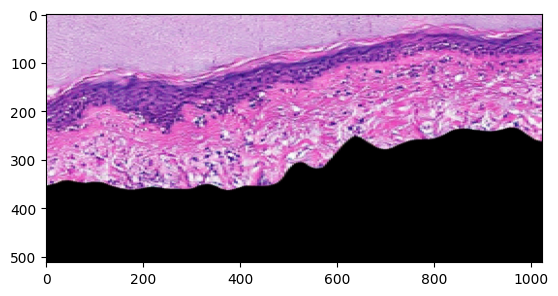

In [4]:
# Load OCT image
oct_image = cv2.imread(oct_input_image_path)
if oct_image is None:
  raise FileNotFoundError(f"The file '{oct_input_image_path}' was not found.")

# Cropping
cropped = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0)

# Run Inference
virtual_histology_image, masked_image , o2h_input = oct2hist.run_network(
    cropped,
    microns_per_pixel_x = microns_per_pixel_x,
    microns_per_pixel_z = microns_per_pixel_z,
    # min_signal_threshold = 0.15, # Un comment this part to skip the auto threshold discovery
    )

# Show the virtual histology image result
showImg(virtual_histology_image)

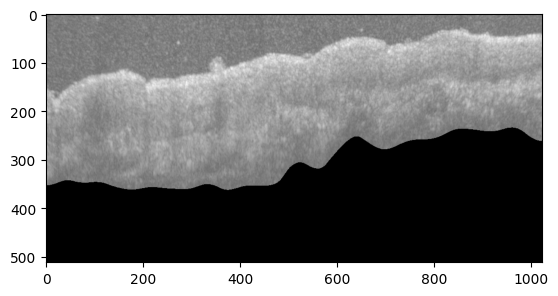

In [5]:
#@title Masked Image
showImg(masked_image)

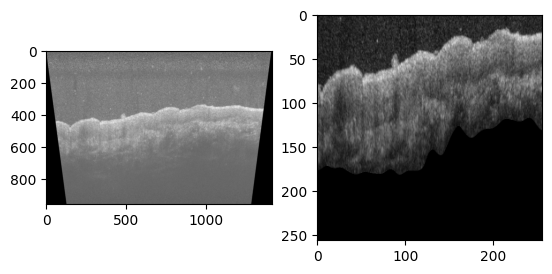

In [6]:
#@title Pre Processing Results (before - left, after preprocessing - right)
showTwoImgs(oct_image, o2h_input)

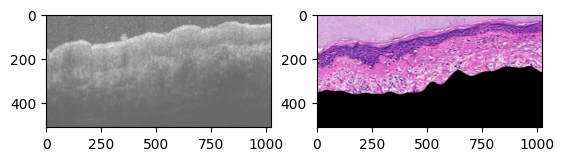

In [7]:
#@title Final Results
showTwoImgs(cropped, virtual_histology_image)

In [ ]:
# Run tiled inference (calls test_on_tiles.py)
import os
# change into submodule before run
os.chdir(f"{REPO_ROOT}/OCT2Hist_UseModel/pytorch_CycleGAN_and_pix2pix")
cli = f'''
python test_on_tiles.py   --netG {NETG}   --dataroot "{DATAROOT}"   --model {MODEL}   --name "{NAME}"   --checkpoints_dir "{CHECKPOINTS_DIR}"   --results_dir "{RESULTS_DIR}"   --num_test {NUM_TEST}   --tta_per_image   --tta_iters {TTA_ITERS}   --tta_patience {TTA_PATIENCE}   --tta_sigma {TTA_SIGMA}   --tta_lambda_h {TTA_LAMBDA_H}   --tta_lambda_tv {TTA_LAMBDA_TV}   --tta_debug_every {TTA_DEBUG_EVERY}   --tta_debug_dir "{TTA_DEBUG_DIR}"   --batch_size {BATCH_SIZE}   --tta_overlap {TTA_OVERLAP}   --learning_rate {LEARNING_RATE}
'''
print(cli)
os.system(cli)
